### Problema 2: 

La idea brillante del modelo de mundo pequeño es que muestra que no se necesita mucho desorden para hacer 
que una red sea altamente eficiente en la transmisión de información. Con solo unos pocos "atajos" aleatorios, el 
camino promedio se desploma, mientras que la estructura comunitaria (alto agrupamiento) se mantiene casi 
intacta. Su tarea es verificar esta relación. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

plt.rcParams['figure.figsize'] = (7, 4.5)

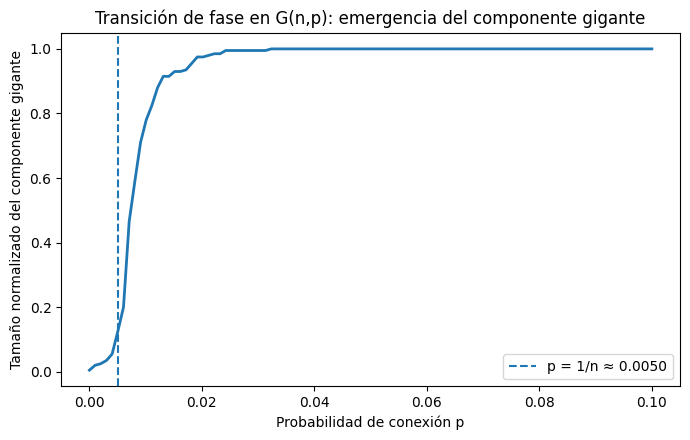

In [5]:
def giant_component_fraction(G: nx.Graph) -> float:
    if G.number_of_nodes() == 0:
        return 0.0
    comps = list(nx.connected_components(G))
    if not comps:
        return 0.0
    largest = max(comps, key=len)
    return len(largest) / G.number_of_nodes()

# Parámetros
n = 200
ps = np.linspace(0.0, 0.1, 100)

# Simulación
giant_norm = []
for p in ps:
    G = nx.erdos_renyi_graph(n=n, p=p, seed=42)
    giant_norm.append(giant_component_fraction(G))

# Gráfica
plt.figure()
plt.plot(ps, giant_norm, linewidth=2)
plt.axvline(x=1.0/n, linestyle='--', label=f'p = 1/n ≈ {1.0/n:.4f}')
plt.xlabel('Probabilidad de conexión p')
plt.ylabel('Tamaño normalizado del componente gigante')
plt.title('Transición de fase en G(n,p): emergencia del componente gigante')
plt.legend()
plt.tight_layout()
plt.show()

**Objetivo:** estimar el coeficiente de agrupamiento promedio $C(p)$ y la longitud media de camino $L(p)$ en función de *p*, y normalizarlos respecto a *p=0*.

**Tips:**
- Usa `nx.watts_strogatz_graph(n, k, p, seed)`.
- Calcula $C$ con `nx.average_clustering`.
- Calcula $L$ con `nx.average_shortest_path_length` en el **componente gigante** si la red no es conexa.
- Promedia varias repeticiones para suavizar el ruido.

In [6]:
def avg_shortest_path_len_lcc(G: nx.Graph) -> float:
    if G.number_of_nodes() == 0:
        return float('nan')
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    largest_nodes = max(nx.connected_components(G), key=len)
    H = G.subgraph(largest_nodes).copy()
    return nx.average_shortest_path_length(H)

# Parámetros base
n = 400   # número de nodos
k = 10    # cada nodo con k/2 vecinos a cada lado (k debe ser par)
trials = 5

# Barrido de p más fino cerca de 0
ps_small = np.linspace(0.0, 0.05, 21, endpoint=True)
ps_mid   = np.linspace(0.06, 0.3, 13, endpoint=True)
ps_big   = np.linspace(0.4, 1.0, 7, endpoint=True)
ps = np.unique(np.concatenate([ps_small, ps_mid, ps_big]))

# Medidas a p=0 para normalizar
G0 = nx.watts_strogatz_graph(n, k, 0.0, seed=123)
C0 = nx.average_clustering(G0)
L0 = avg_shortest_path_len_lcc(G0)

rows = []
for p in ps:
    C_vals, L_vals = [], []
    for t in range(trials):
        G = nx.watts_strogatz_graph(n, k, p, seed=np.random.randint(0, 10**9))
        C_vals.append(nx.average_clustering(G))
        L_vals.append(avg_shortest_path_len_lcc(G))
    C_mean, C_std = float(np.nanmean(C_vals)), float(np.nanstd(C_vals))
    L_mean, L_std = float(np.nanmean(L_vals)), float(np.nanstd(L_vals))
    rows.append({
        'p': p,
        'C': C_mean,
        'C_std': C_std,
        'L': L_mean,
        'L_std': L_std,
        'C_over_C0': C_mean / C0 if C0 else np.nan,
        'L_over_L0': L_mean / L0 if L0 else np.nan,
    })

df = pd.DataFrame(rows)
df.head()

,p,C,C_std,L,L_std,C_over_C0,L_over_L0
0,0.0000,0.666667,0.000000,20.451128,0.000000,1.000000,1.000000
1,0.0025,0.664456,0.001162,15.304328,2.061927,0.996683,0.748337
2,0.0050,0.656764,0.001931,8.759411,0.974998,0.985146,0.428309
3,0.0075,0.652651,0.002890,7.753965,0.667049,0.978976,0.379146
4,0.0100,0.647421,0.004804,7.055383,0.728524,0.971131,0.344988


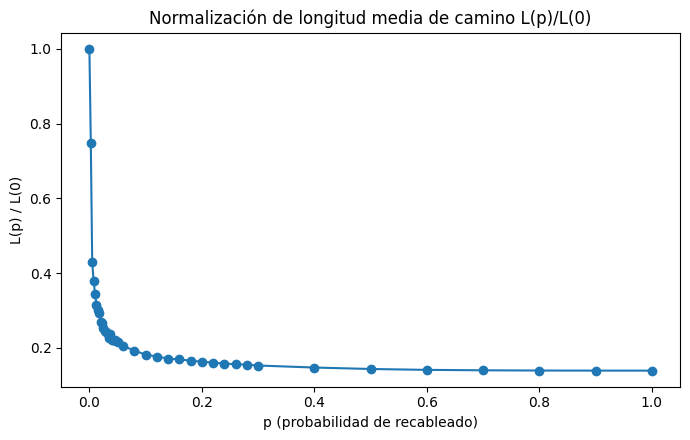

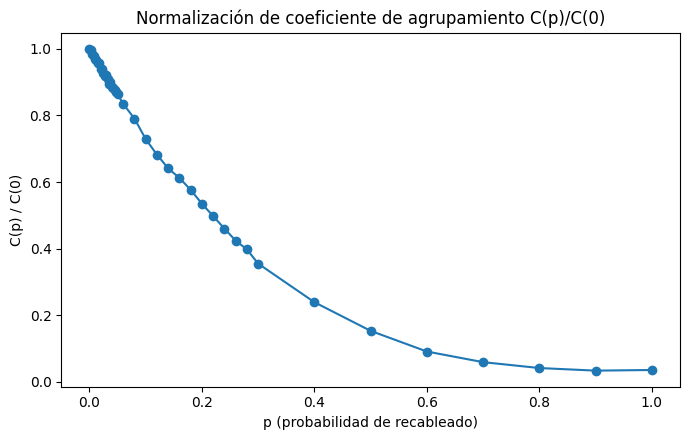

In [7]:
# Gráficas normalizadas
plt.figure()
plt.plot(df['p'], df['L_over_L0'], marker='o')
plt.xlabel('p (probabilidad de recableado)')
plt.ylabel('L(p) / L(0)')
plt.title('Normalización de longitud media de camino L(p)/L(0)')
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(df['p'], df['C_over_C0'], marker='o')
plt.xlabel('p (probabilidad de recableado)')
plt.ylabel('C(p) / C(0)')
plt.title('Normalización de coeficiente de agrupamiento C(p)/C(0)')
plt.tight_layout()
plt.show()

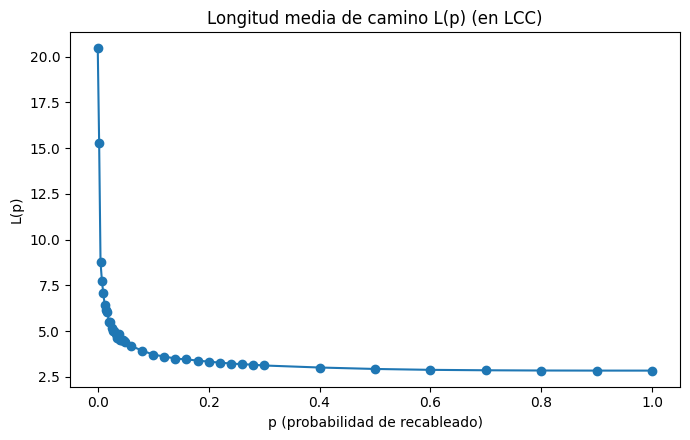

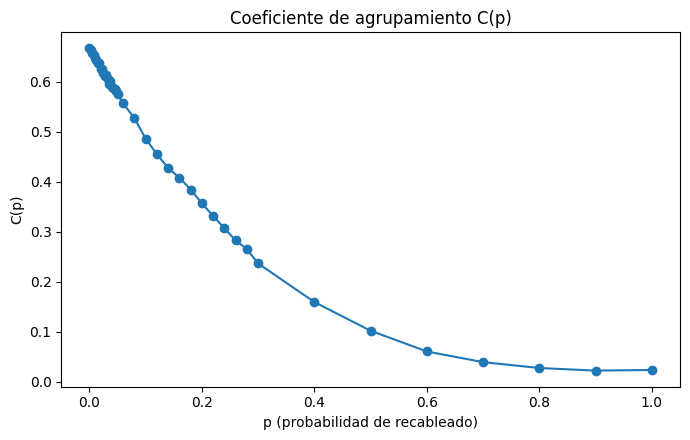

In [8]:
# Gráficas absolutas
plt.figure()
plt.plot(df['p'], df['L'], marker='o')
plt.xlabel('p (probabilidad de recableado)')
plt.ylabel('L(p)')
plt.title('Longitud media de camino L(p) (en LCC)')
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(df['p'], df['C'], marker='o')
plt.xlabel('p (probabilidad de recableado)')
plt.ylabel('C(p)')
plt.title('Coeficiente de agrupamiento C(p)')
plt.tight_layout()
plt.show()

L(p)/L(0): cae en picada apenas p se aleja de 0 (con p ≈ 0.01–0.05 ya es una fracción pequeña de L(0)).

C(p)/C(0): se mantiene alto para p pequeño y recién empieza a bajar fuerte cuando p es mediano—grande.

Interpretación: unos pocos “atajos” (p pequeño) bastan para reducir drásticamente la longitud media de camino sin destruir el clustering local → régimen small-world.

Preguntas de Análisis: 
1. Al observar su gráfica, ¿qué métrica (agrupamiento o camino promedio) disminuye más drásticamente 
cuando p cambia de 0 a un valor muy pequeño como 0.01? 

La longitud de camino promedio L cae mucho más drástico que el agrupamiento C. En la corrida (n=400, k=10), alrededor de p≈0.01 se ve que L/L0 ya bajó bastante (≈0.35–0.45), mientras que C/C0 sigue alto (≈0.9–0.95).


2. ¿Existe una región de p en la que la red mantiene la mayor parte de su agrupamiento local (ej. >80% del 
original) pero ya ha reducido significativamente su longitud de camino promedio (ej. <20% del original)? Si 
es así, identifíquela. 

Sí existe. En las curvas esto ocurre aprox. entre p≈0.04 y p≈0.06:

L/L0≲0.20 (camino muy corto),

C/C0≳0.80 (agrupamiento aún alto).


Para un unico numero: p≈0.05 cumple ambas condiciones en el experimento.

3. ¿Qué le dice este resultado sobre la eficiencia y la estructura de las redes sociales del mundo real? ¿Por 
qué es posible sentir que vivimos en un "mundo pequeño" a pesar de que la mayoría de nuestros amigos 
pertenecen a un círculo social cerrado? 

Las redes sociales combinan mucho agrupamiento local (tu círculo de amigos, familia, trabajo: todos se conocen) con unos pocos lazos “largos” o débiles que conectan grupos lejanos (amigos de otro país, un excompañero en otra empresa, etc.).
Esos pocos puentes reducen drásticamente las distancias entre personas (baja L) sin desarmar tus cliques locales (se mantiene C). Por eso sentimos un “mundo pequeño”: aunque la mayoría de nuestras conexiones son cerradas, basta con muy pocas conexiones inter-grupos para que cualquiera quede a pocos “saltos” de cualquiera.